# Neuroimaging week ...: Raw MRI data and k-space transform
## Raw MRI data
In this week's lab we will focus on what the raw MRI data look like and how they are produced. The MRI signal is produced through a physical phenomenon called nuclear magnetic resonance, where nuclei (e.g. water protons) in a strong magnetic field produce a signal if they are *excited* with a radiofrequency pulse. The MRI signal that we get from the scanner is a complex number, i.e. it includes a magnitude and a phase component. 

In this tutorial, we'll be going through the conversions between k-space (Fourier, or frequency-space) data and image-space data by means of the inverse fourier and fourier transforms. We acquire radio signals in the scanner, and we can encode space in terms of the frequencies and phases of these radio signals. But because we measure these signals in frequency/k-space, we'll need to do these conversions. 

Throughout we'll be working with complex numbers, which have a real and an imaginary part. These complex numbers can be converted to a magnitude (amplitude, strength) and a phase (a circular quantity, like the seconds on a clock face or the angle along a circle). If you're not familiar with complex numbers, don't worry, most of the conversions should be understandable without any deep math skills. 

Parts of this tutorial were adapted from a matlab example by Laurentius Huber (@layerfmri on Twitter)

In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [4]:
magnitude_mat = scipy.io.loadmat('matlab_FLASH_MAGN.mat')
phase_mat = scipy.io.loadmat('matlab_FLASH_PHASE.mat')

"FLASH" is a specific type of scan, not important for now. What is important is that we have our data in image format, encoded in the magnitude and phase of its complex numbers. These components can be combined to its complex number form:

In [18]:
z=magnitude_mat['a']*np.exp(1j*(phase_mat['a']/4096*np.pi))
print(z)

[[ 0.        +0.j         -1.8830882 +0.6737796j  -1.6509124 +1.1289324j
  ...  3.1123064 -3.9132533j   0.66221255-1.8871869j
  -3.0701084 -3.946446j  ]
 [ 0.        +0.j         -0.10106996+0.9948793j   0.5776327 +1.914769j
  ... -0.5383231 -3.9636104j   1.9715928 -3.4803479j
  -2.7043712 -2.9472659j ]
 [ 0.        +0.j          0.99985766+0.01687299j  1.8892096 +0.6564197j
  ...  0.        +0.j         -0.57329714-0.8193475j
  -1.8855873 -3.527685j  ]
 ...
 [ 0.        +0.j         -1.0839775 -2.797319j   -1.874579  -2.3422112j
  ... -0.6707673 -2.9240503j  -2.5684419 -1.5501955j
  -0.5695205 -0.82197714j]
 [ 0.        +0.j         -3.1541462 -3.8796086j  -1.7416842 -0.98312575j
  ...  0.4356388 -2.9682014j  -0.7564051 -4.9424543j
   0.84394944-5.940349j  ]
 [ 0.        +0.j         -1.9534003 -0.42921725j -1.5499063 -1.2640374j
  ...  0.5310126 -2.9526303j  -2.509244  -6.5348063j
  -3.6849976 -8.211017j  ]]


... and the magnitude and phase images can be plotted. You get the magnitude of a complex number by `np.absolute`, and its phase by `np.angle`.

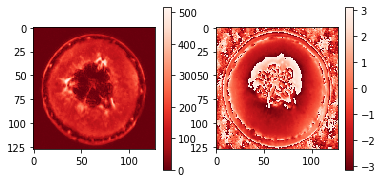

In [19]:
# plot your magnitude and phase
fig, (ax1, ax2) = plt.subplots(figsize=(6, 3), ncols=2)
magplt = ax1.imshow(np.absolute(z), cmap='Reds_r', interpolation='none')
fig.colorbar(magplt, ax=ax1)
phaseplt = ax2.imshow(np.angle(z), cmap='Reds_r', interpolation='none')
fig.colorbar(phaseplt, ax=ax2)
plt.show()

**Question**: Can you tell what type of object was scanned here?

Note that contrast is easier to discern in the magnitude image of the ... pumpkin, so we typically just use that in (f)MRI images, with the phase image discarded. 

## K-space data

From the raw signal from a nuclear magnetic resonance experiment, there is no way to differentiate the signal from, say, different regions of the brain, i.e. there is no *spatial encoding* of the signal.

Lauterbur won a Nobel by discovering a way to spatially encode the signal. Essentially, the spatial information is transformed to a set of frequencies with a magnetic gradient along the object that we want to image. In practice, this is a real-life Fourier transform from a euclidean space to a frequency space. To get a feeling of how any time-varying signal can be equivalenty expressed as a combination of periodic signals, check this introductory video to Fourier transform:
https://youtu.be/spUNpyF58BY

This frequency space is what the MR scanner actually records and is called the *k-space*. 

We then *reconstruct* the spatial signal, by again applying a Fourier transform. We can see what the k-space looks like by applying a Fourier transform to our image data:

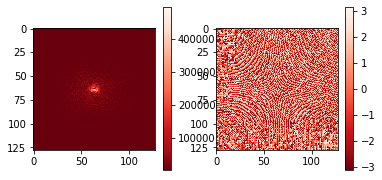

In [20]:
# k-Space transform
A=np.fft.fft2(z)
A=np.fft.fftshift(A)

# don't worry about why we're implementing this fftshift thing - 
# that's just to complete the operation of going back and forth 
# between k-space and image-space. You'll see it appear over and over. 

# plot your magnitude and phase
fig, (ax1, ax2) = plt.subplots(figsize=(6, 3), ncols=2)
magplt = ax1.imshow(np.absolute(A), cmap='Reds_r', interpolation='none')
fig.colorbar(magplt, ax=ax1)
phaseplt = ax2.imshow(np.angle(A), cmap='Reds_r', interpolation='none')
fig.colorbar(phaseplt, ax=ax2)
plt.show()

Note that *there is no one-to-one relationship between the a point in the image space and a point in the k-space*. Instead, most of the signal of the magnitude k-space is in the center. This represents the frequencies that save the gross spatial characteristics of the image. The finer spatial detail is instead encoded in the outer parts of the k-space. We can easily check what part of the k-space encodes what spatial signal, by masking the inner and outer k-space, in effect taking out a square portion from the center of k-space:   

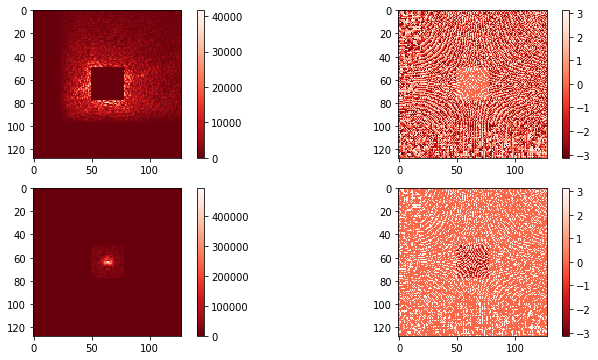

In [21]:
# mask k space borders
def mask_borders(arr, num=50):
    mask = np.zeros(arr.shape, bool)
    for dim in range(arr.ndim):
        mask[tuple(slice(0, num) if idx == dim else slice(None) for idx in range(arr.ndim))] = True  
        mask[tuple(slice(-num, None) if idx == dim else slice(None) for idx in range(arr.ndim))] = True  
    return mask

outer_kspace=A*mask_borders(A)
inner_kspace=A*np.invert(mask_borders(A))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 6), ncols=2, nrows=2)
magplt = ax1.imshow(np.absolute(outer_kspace), cmap='Reds_r', interpolation='none')
fig.colorbar(magplt, ax=ax1)
phaseplt = ax2.imshow(np.angle(outer_kspace), cmap='Reds_r', interpolation='none')
fig.colorbar(phaseplt, ax=ax2)
magplt = ax3.imshow(np.absolute(inner_kspace), cmap='Reds_r', interpolation='none')
fig.colorbar(magplt, ax=ax3)
phaseplt = ax4.imshow(np.angle(inner_kspace), cmap='Reds_r', interpolation='none')
fig.colorbar(phaseplt, ax=ax4)
plt.show()

We can then reconstruct our images, by using again a Fourier tranform:

In [22]:
# reconstruct image 
imagefrom_full_kspace=np.fft.ifftshift(A)
imagefrom_full_kspace=np.fft.ifft2(imagefrom_full_kspace)
imagefrom_outer_kspace=np.fft.ifftshift(outer_kspace)
imagefrom_outer_kspace=np.fft.ifft2(imagefrom_outer_kspace)
imagefrom_inner_kspace=np.fft.ifftshift(inner_kspace)
imagefrom_inner_kspace=np.fft.ifft2(imagefrom_inner_kspace)

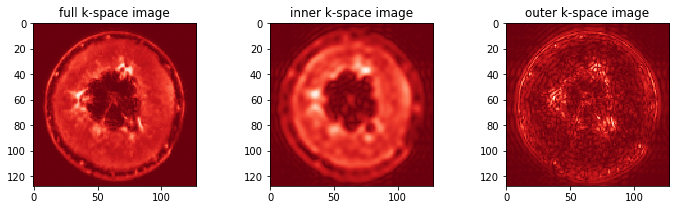

In [23]:
# plot the image reconstructed from inner and outer kspace
fig2, (ax1, ax2,ax3) = plt.subplots(figsize=(12, 3), ncols=3)
fullplt = ax1.imshow(np.absolute(imagefrom_full_kspace), cmap='Reds_r', interpolation='none')
ax1.set_title('full k-space image')
innplt = ax2.imshow(np.absolute(imagefrom_inner_kspace), cmap='Reds_r', interpolation='none')
ax2.set_title('inner k-space image')
outplt = ax3.imshow(np.absolute(imagefrom_outer_kspace), cmap='Reds_r', interpolation='none')
ax3.set_title('outer k-space image')
plt.show()

On the left side, we see our original image. In the middle, we see the image reconstructed from the center of the k-space. Note that it looks like a lower-resolution version of the original image. On the right, we see the image reconstructed from the outer part of the k-space. This largely records the finer detail. 
To get a higher resolution image, we need to encode our signal with higher spatial frequencies. We need therefore to record a larger k-space matrix, with more lines on the outsides. This recording requires more time. You can imagine that this quickly becomes prohibitive if we want to sample fMRI images quickly. 

## Undersampling and parallel imaging
To be able to record higher resolution fMRI images quickly, we frequently undersample our k-space data, by recording data from every other row (or skipping even more data). We can simulate this by making every other row zero:

In [11]:
undersampled_kspace_R2=A*0
undersampled_kspace_R2[::2]=A[::2]
undersampled_kspace_R4=A*0
undersampled_kspace_R4[::4]=A[::4]

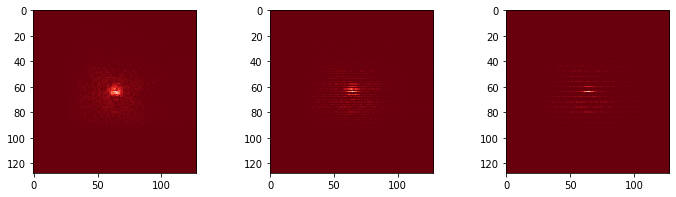

In [24]:
fig3, (ax1, ax2,ax3) = plt.subplots(figsize=(12, 3), ncols=3)
fullplt = ax1.imshow(np.absolute(A), cmap='Reds_r', interpolation='none')
r2plt = ax2.imshow(np.absolute(undersampled_kspace_R2), cmap='Reds_r', interpolation='none')
r4plt = ax3.imshow(np.absolute(undersampled_kspace_R4), cmap='Reds_r', interpolation='none')
plt.show()

In practice, this means that, when we reconstruct our image, the signal from several locations overlaps, creating a folding pattern. You can think of this as if taking out rows in k-space creates spatial uncertainty about the location of an object in image-space. 

In [25]:
imagefrom_undersampled_kspace_R2=np.fft.ifftshift(undersampled_kspace_R2)
imagefrom_undersampled_kspace_R2=np.fft.ifft2(imagefrom_undersampled_kspace_R2)
imagefrom_undersampled_kspace_R4=np.fft.ifftshift(undersampled_kspace_R4)
imagefrom_undersampled_kspace_R4=np.fft.ifft2(imagefrom_undersampled_kspace_R4)

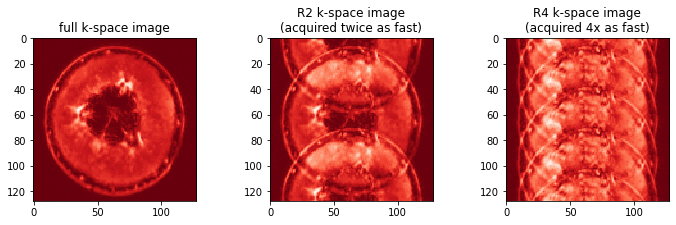

In [26]:
fig4, (ax1, ax2,ax3) = plt.subplots(figsize=(12, 3), ncols=3)
fullplt = ax1.imshow(np.absolute(z), cmap='Reds_r', interpolation='none')
ax1.set_title('full k-space image')
r2plt = ax2.imshow(np.absolute(imagefrom_undersampled_kspace_R2), cmap='Reds_r', interpolation='none')
ax2.set_title('R2 k-space image\n(acquired twice as fast)')
r4tplt = ax3.imshow(np.absolute(imagefrom_undersampled_kspace_R4), cmap='Reds_r', interpolation='none')
ax3.set_title('R4 k-space image\n(acquired 4x as fast)')
plt.show()

As you can see, the more we undersample our data, the more severe the folding (*aliasing*) becomes. We can resolve the *aliasing* by using an additional (implicit) spatial encoding mechanism: in modern MRI, we record our signal with multiple small *receive coils* (parallel MRI), since this achieves higher SNR. These small coils are characterized by signal sensitivity to specific areas of the object, rather than the whole object. By modeling this coil sensitivity profile, we can resolve  the spatial origin of the signal and unfold the image.

But this is not perfect - the aliasing you see above is actually a very common artifact that we see in MRI images. MRIQC even has dedicated visualizations that it does to detect them - it shows a detailed image of the air outside the head to see if any of these 'ghosts' appear.

As a guiding principle, a higher-number of smaller receive coils allow higher undersampling factors. Modern research coil arrays frequently use 32 or 64 coils. This along with improved unfolding algorithms allows undersampling factors of up to 4-6 in a single direction, vastly reducing the amount of data we need to record and allowing us to increase our spatial and temporal fMRI resolution. A big boost for undersampling approaches for fMRI was given by the Human Connectome Project. Coils and undersamling techniques for fMRI remain an active research area.

## Distortions in fMRI data
In the most basic MRI acquisition, we excite the nuclei and within very few milliseconds we sample the k-space, to record our signal. This is a method that takes a lot of time, because we constantly need to excite and wait a few milliseconds. A more efficient way to do this is what we call Echo Planar Imaging (EPI). In the most common EPI case, we apply a single excitation and quickly transverse through a large chunk of k-space in a cartesian manner, collecting data as quickly as possible. To achieve this, complex technical challenges were solved to implement the strong magnetic gradients that encode the signal. Initially, this method was created to image the beating human heart and was so influential that was awarded a Nobel prize (Mansfield). We quickly discovered that this method could also track small changes in deoxyhemoglobin (deoxygenated blood), as part of the hemodynamic response to neuronal activation (fMRI). Quick sampling is essential for fMRI to get as close to the temporal scale that the brain operates as possible.

Running quickly through the k-space without pause comes at a cost though: the signal dephases while we are sampling it. This means that the signal builds a stronger phase, gets weaker and, because we use the phase information to encode the location of the signal, our image experiences a distortion in relation to when we sample it. This happens particularly quickly in neighoboring areas with different magnetic susceptibility (frequency offset field). First, lets simulate the signal experiencing dephasing at different sampling timepoints:

In [15]:
ESP = 500e-7;                 # Echo spacing [s] (i.e. how quickly we sample)

# Create a time series of phantoms with off-resonance phase accumulation 
N=z.shape[1];
Obj0_dist = np.repeat(z[:, :, np.newaxis], N, axis=2)
freq=1.8*(np.linspace(0,5,N))**2;  # an arbitrary magnetic susceptibility gradient [Hz] that we haven't managed to correct for
freq_scl=freq[:,None]*freq;
disp=freq_scl*ESP*N;

# simulation of the signal we would receive with different phase buildups
for n in range(N): 
	phs_off = np.exp(-1j*2*3.14*freq_scl*ESP*n);     # Phase from off-resonance per echo
	Obj0_dist[:,:,n]=Obj0_dist[:,:,n]*phs_off;       # Object accumulates phase during EPI duration
    
# k-space transform (i.e. what we are actually measuring)
kspc_dist=np.zeros(Obj0_dist.shape);
for n in range(N):
	kspc_dist[:,:,n]=np.fft.fft2(Obj0_dist[:,:,n])
	kspc_dist[:,:,n]=np.fft.fftshift(kspc_dist[:,:,n])
    

/var/folders/k3/92tfyz4d2dv2c7xmm2bq8s_h0000gn/T/ipykernel_5782/3798435616.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  kspc_dist[:,:,n]=np.fft.fft2(Obj0_dist[:,:,n])


As we mentioned, we are not actually measuring the whole signal at the same time, but in a cartesian trajectory (i.e. something like: 1st line -> immediately, 2nd line -> a bit after, etc). This we can simulate by colecting each k-space line at a different time point, say starting from the top towards the bottom:

In [16]:
kspc_epi_dist = np.zeros(z.shape)
for n in range(N): kspc_epi_dist[n,:] = kspc_dist[n,:,n]; # Grab one echo per ky-line during phase accumulation

IM_epi_dist=np.fft.ifftshift(kspc_epi_dist)
IM_epi_dist=np.fft.ifft2(IM_epi_dist)

As you can see, adding a frequency offset (middle image) results in a spatial distortion and extra "phase wraps", a sign of our signal dephasing for longer.

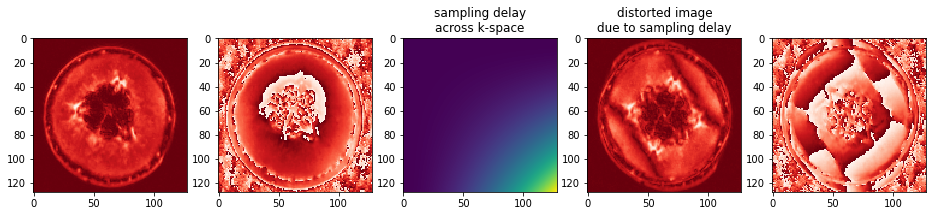

In [17]:
fig5, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(figsize=(16, 3), ncols=5)
magplt = ax1.imshow(np.absolute(z), cmap='Reds_r', interpolation='none')						# initial magnitude
phaplt = ax2.imshow(np.angle(z), cmap='Reds_r', interpolation='none') 							# initial phase
disper=ax3.imshow(np.absolute(disp)) 															# added frequency offset
ax3.set_title('sampling delay\nacross k-space')
magplt_distorted = ax4.imshow(np.absolute(IM_epi_dist), cmap='Reds_r', interpolation='none')	# distorted magnitude
ax4.set_title('distorted image\ndue to sampling delay')
phaplt_distorted = ax5.imshow(np.angle(IM_epi_dist), cmap='Reds_r', interpolation='none')		# distorted phase
plt.show()

The EPI distortion can be pretty severe in fMRI data. This is problematic, because fMRI images typically do not have great anatomical detail, so we need to overlay the fMRI images to higher-resolution anatomical images researchers typically acquire to find where exactly they are in the brain. 

The dephasing is an effect that gets more severe at higher field strengths (stronger frequency offsets) and when we extend the time between succesive excitations to scan high-resolution data quickly, so it is very common in state-of-the-art high-resolution studies. To reduce it, people either try to measure the field offset, or more commonly, acquire data with the opposite sampling direction (e.g. from bottom to top), so that the image is distorted in the opposite direction. One can then calculate by how much they need to move each voxel to correct for the distortion.

In [ ]:
# Simulate the DOWN-TOP EPI trajectory...grab one k-line from each time
kspc_epi_dist_DOWNTOP = np.zeros(z.shape)
for n in range(N): kspc_epi_dist_DOWNTOP[N-(n+1),:] = kspc_dist[N-(n+1),:,n]; # Grab one echo per ky-line during phase accumulation

IM_epi_dist_DOWNTOP=np.fft.ifftshift(kspc_epi_dist_DOWNTOP)
IM_epi_dist_DOWNTOP=np.fft.ifft2(IM_epi_dist_DOWNTOP)

Here, the undistorted image and the distorted images with top-bottom sampling and bottom-top sampling:

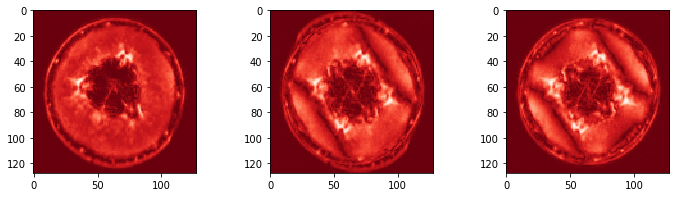

In [ ]:
fig6, (ax1, ax2,ax3) = plt.subplots(figsize=(12, 3), ncols=3)
magplt = ax1.imshow(np.absolute(z), cmap='Reds_r', interpolation='none')
magplt_distorted = ax2.imshow(np.absolute(IM_epi_dist), cmap='Reds_r', interpolation='none')
magplt_distorted_DOWNTOP = ax3.imshow(np.absolute(IM_epi_dist_DOWNTOP), cmap='Reds_r', interpolation='none')
plt.show()

Note that while using these opposite-sampling-direction images is a common step in fMRI preprocessing for 7T fMRI, it is far from perfect. Signal dephasing and spatial distortions can also be dynamic, due to breathing or participant movement. Researchers need to seriously take such effects into account when designing their experiment to ensure that they can visualize their areas of interest with high-fidelity.

To evaluate the quality of the fMRI signal, several measures have been suggested. One of the most common and simple ones is the temporal SNR, i.e. 

temporal SNR = mean (signal) / std (signal).

 



## Summary
Overall, now you have an overview of how raw MRI data look (complex matrix), how they are produced (NMR phenomenon + k-space encoding through Fourier transform) and what values in k-space represent (frequencies  - with the slower ones (middle of k-space) carrying most of the SNR and the outer k-space having the high-resolution information).

You have seen how we can accelerate MRI e.g. for a fast fMRI acquisition, by undersampling, which causes aliasing artifacts. This can be resolved by receiving signals with multiple sensors at different locations (multiple receive coils). 

You have also simulated how the EPI signal (the most common fMRI acquisition method) works, balancing sampling speed with spatial accuracy and signal quality: the more time we allow the signal to dephase, the more distorted the image becomes in relation to the underlying frequency offset field. This can be partially resolved using opposite-polarity acquisitions, but at a signal quality cost. Measures such as tSNR can inform us about the signal quality overall.

We hope that this notebook gives you a bit of an idea how the scanner works in terms of the conversion from radio signals to images. Don't worry if some of this fourier transform stuff was abracadabra - you won't be quizzed on it during the exam. If you find it interesting, though, feel free to contact us for an internship at the Spinoza Centre. 